# About dataset

Imagine that you are a medical researcher compiling data for a study. You have collected data about a set of patients, all of whom suffered from the same illness. During their course of treatment, each patient responded to one of 5 medications, Drug A, Drug B, Drug c, Drug x and y.

Part of your job is to build a model to find out which drug might be appropriate for a future patient with the same illness. The features of this dataset are Age, Sex, Blood Pressure, and the Cholesterol of the patients, and the target is the drug that each patient responded to.

It is a sample of multiclass classifier, and we can use the training part of the dataset to build a decision tree, and then use it to predict the class of a unknown patient, or to prescribe a drug to a new patient.

In [1]:
# ============================
# 1. IMPORTS & CONFIG
# ============================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report
)

pd.set_option("display.max_columns", None)
pd.set_option("display.precision", 3)


In [2]:
# ============================
# 2. LOAD DATA & BASIC EDA
# ============================
df = pd.read_csv("drug200.csv")

print("Shape of dataset:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nData types:")
print(df.dtypes)

print("\nClass distribution (Drug):")
print(df["Drug"].value_counts())

print("\nUnique values per categorical feature:")
print("Sex:", df["Sex"].unique())
print("BP:", df["BP"].unique())
print("Cholesterol:", df["Cholesterol"].unique())


Shape of dataset: (200, 6)

First 5 rows:


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY



Data types:
Age              int64
Sex             object
BP              object
Cholesterol     object
Na_to_K        float64
Drug            object
dtype: object

Class distribution (Drug):
Drug
drugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: count, dtype: int64

Unique values per categorical feature:
Sex: ['F' 'M']
BP: ['HIGH' 'LOW' 'NORMAL']
Cholesterol: ['HIGH' 'NORMAL']


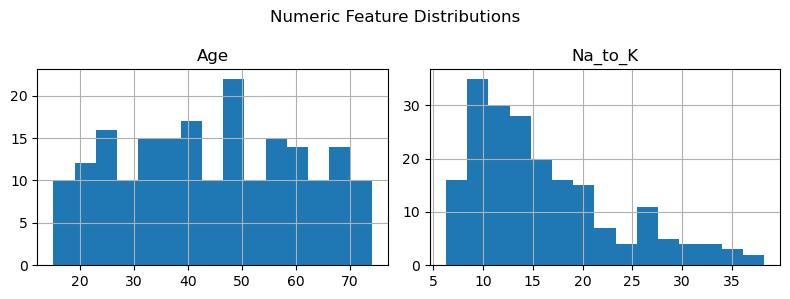

In [3]:
# histograms for numeric features
numeric_cols = ["Age", "Na_to_K"]
df[numeric_cols].hist(figsize=(8, 3), bins=15)
plt.suptitle("Numeric Feature Distributions")
plt.tight_layout()
plt.show()


In [4]:
# ============================
# 3. FEATURE/TARGET SPLIT & ENCODING
# ============================

# Features and target
X = df[["Age", "Sex", "BP", "Cholesterol", "Na_to_K"]].copy()
Y = df["Drug"].copy()

# We will encode categorical features using LabelEncoder.
X_encoded = X.copy()
label_encoders = {}

for col in ["Sex", "BP", "Cholesterol"]:
    le = preprocessing.LabelEncoder()
    X_encoded[col] = le.fit_transform(X[col])
    label_encoders[col] = le  # store encoder for possible inverse_transform later

print("Encoded feature sample:")
display(X_encoded.head())

# Class names for later use in confusion matrix & tree plot
class_names = np.unique(Y)
print("Class names:", class_names)

feature_names = X_encoded.columns.tolist()
print("Feature names:", feature_names)


Encoded feature sample:


,Age,Sex,BP,Cholesterol,Na_to_K
0,23,0,0,0,25.355
1,47,1,1,0,13.093
2,47,1,1,0,10.114
3,28,0,2,0,7.798
4,61,0,1,0,18.043


Class names: ['drugA' 'drugB' 'drugC' 'drugX' 'drugY']
Feature names: ['Age', 'Sex', 'BP', 'Cholesterol', 'Na_to_K']


In [5]:
# ============================
# 4. TRAIN/TEST SPLIT
# ============================
X_train, X_test, Y_train, Y_test = train_test_split(
    X_encoded,
    Y,
    test_size=0.3,
    random_state=42,
    stratify=Y  # keep class proportions
)

print("Train size:", X_train.shape[0])
print("Test size :", X_test.shape[0])


Train size: 140
Test size : 60


In [6]:
# ============================
# 5. BASELINE DECISION TREE
# ============================
baseline_dt = DecisionTreeClassifier(
    random_state=42
)
baseline_dt.fit(X_train, Y_train)

Y_train_pred_base = baseline_dt.predict(X_train)
Y_test_pred_base = baseline_dt.predict(X_test)

print("=== Baseline Decision Tree ===")
print("Train accuracy:", accuracy_score(Y_train, Y_train_pred_base))
print("Test accuracy :", accuracy_score(Y_test, Y_test_pred_base))
print("\nClassification report (baseline, test set):")
print(classification_report(Y_test, Y_test_pred_base))


=== Baseline Decision Tree ===
Train accuracy: 1.0
Test accuracy : 0.9833333333333333

Classification report (baseline, test set):
              precision    recall  f1-score   support

       drugA       0.88      1.00      0.93         7
       drugB       1.00      0.80      0.89         5
       drugC       1.00      1.00      1.00         5
       drugX       1.00      1.00      1.00        16
       drugY       1.00      1.00      1.00        27

    accuracy                           0.98        60
   macro avg       0.97      0.96      0.96        60
weighted avg       0.99      0.98      0.98        60



In [7]:
# ============================
# 6. HYPERPARAMETER TUNING (GRIDSEARCHCV)
# ============================

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [2, 3, 4, 5, 6, None],
    "min_samples_split": [2, 4, 6, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

grid_dt.fit(X_train, Y_train)

print("Best parameters:", grid_dt.best_params_)
print("Best cross-validation accuracy:", grid_dt.best_score_)


Best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 1.0


In [8]:
# ============================
# 6. HYPERPARAMETER TUNING (GRIDSEARCHCV)
# ============================

param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "max_depth": [2, 3, 4, 5, 6, None],
    "min_samples_split": [2, 4, 6, 10],
    "min_samples_leaf": [1, 2, 4]
}

grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring="accuracy",
    cv=5,
    n_jobs=-1
)

grid_dt.fit(X_train, Y_train)

print("Best parameters:", grid_dt.best_params_)
print("Best cross-validation accuracy:", grid_dt.best_score_)


Best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best cross-validation accuracy: 1.0


In [9]:
# ============================
# 7. FINAL TUNED DECISION TREE
# ============================
best_params = grid_dt.best_params_
final_dt = DecisionTreeClassifier(
    random_state=42,
    **best_params
)

final_dt.fit(X_train, Y_train)

Y_train_pred = final_dt.predict(X_train)
Y_test_pred = final_dt.predict(X_test)

print("=== Final Tuned Decision Tree ===")
print("Train accuracy:", accuracy_score(Y_train, Y_train_pred))
print("Test accuracy :", accuracy_score(Y_test, Y_test_pred))

print("\nClassification report (final model, test set):")
print(classification_report(Y_test, Y_test_pred))


=== Final Tuned Decision Tree ===
Train accuracy: 1.0
Test accuracy : 0.9833333333333333

Classification report (final model, test set):
              precision    recall  f1-score   support

       drugA       0.88      1.00      0.93         7
       drugB       1.00      0.80      0.89         5
       drugC       1.00      1.00      1.00         5
       drugX       1.00      1.00      1.00        16
       drugY       1.00      1.00      1.00        27

    accuracy                           0.98        60
   macro avg       0.97      0.96      0.96        60
weighted avg       0.99      0.98      0.98        60



Confusion matrix (raw):
 [[ 7  0  0  0  0]
 [ 1  4  0  0  0]
 [ 0  0  5  0  0]
 [ 0  0  0 16  0]
 [ 0  0  0  0 27]]


<Figure size 600x500 with 0 Axes>

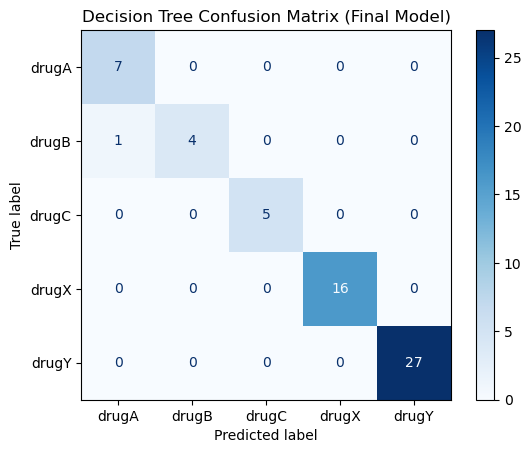

In [10]:
# ============================
# 8. CONFUSION MATRIX
# ============================
cm = confusion_matrix(Y_test, Y_test_pred, labels=class_names)

print("Confusion matrix (raw):\n", cm)

plt.figure(figsize=(6, 5))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Decision Tree Confusion Matrix (Final Model)")
plt.grid(False)
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

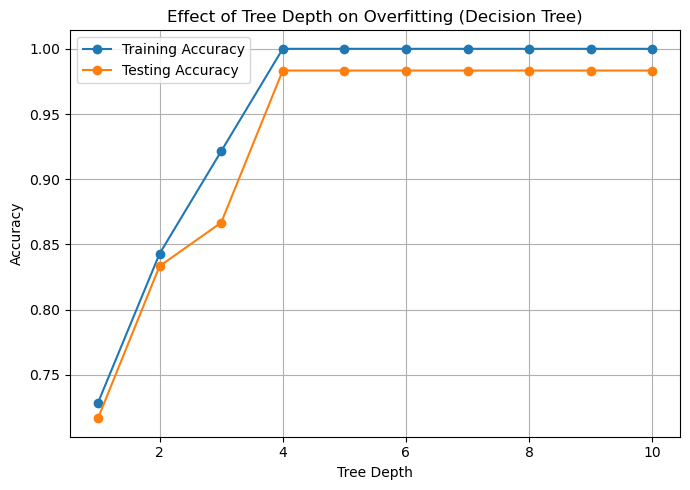

In [11]:
# ============================
# 9. OVERFITTING STUDY: DEPTH VS ACCURACY
# ============================
depths = range(1, 11)
train_scores = []
test_scores = []

for d in depths:
    dt = DecisionTreeClassifier(
        max_depth=d,
        random_state=42,
        criterion=best_params.get("criterion", "gini"),
        min_samples_split=best_params.get("min_samples_split", 2),
        min_samples_leaf=best_params.get("min_samples_leaf", 1),
    )
    dt.fit(X_train, Y_train)
    train_scores.append(dt.score(X_train, Y_train))
    test_scores.append(dt.score(X_test, Y_test))

plt.figure(figsize=(7, 5))
plt.plot(depths, train_scores, marker="o", label="Training Accuracy")
plt.plot(depths, test_scores, marker="o", label="Testing Accuracy")
plt.xlabel("Tree Depth")
plt.ylabel("Accuracy")
plt.title("Effect of Tree Depth on Overfitting (Decision Tree)")
plt.legend()
plt.grid(True)
plt.savefig("depth_vs_accuracy.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

Feature importance:


,Feature,Importance
4,Na_to_K,0.479
2,BP,0.273
0,Age,0.135
3,Cholesterol,0.114
1,Sex,0.000


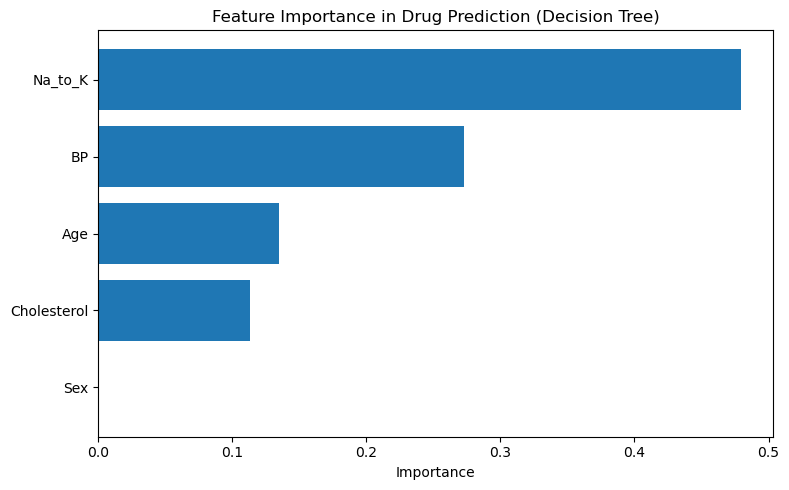

In [12]:
# ============================
# 10. FEATURE IMPORTANCE
# ============================
importances = final_dt.feature_importances_
fi_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("Feature importance:")
display(fi_df)

plt.figure(figsize=(8, 5))
plt.barh(fi_df["Feature"], fi_df["Importance"])
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance in Drug Prediction (Decision Tree)")
plt.savefig("feature_importance.png", dpi=300, bbox_inches="tight")
plt.tight_layout()
plt.show()

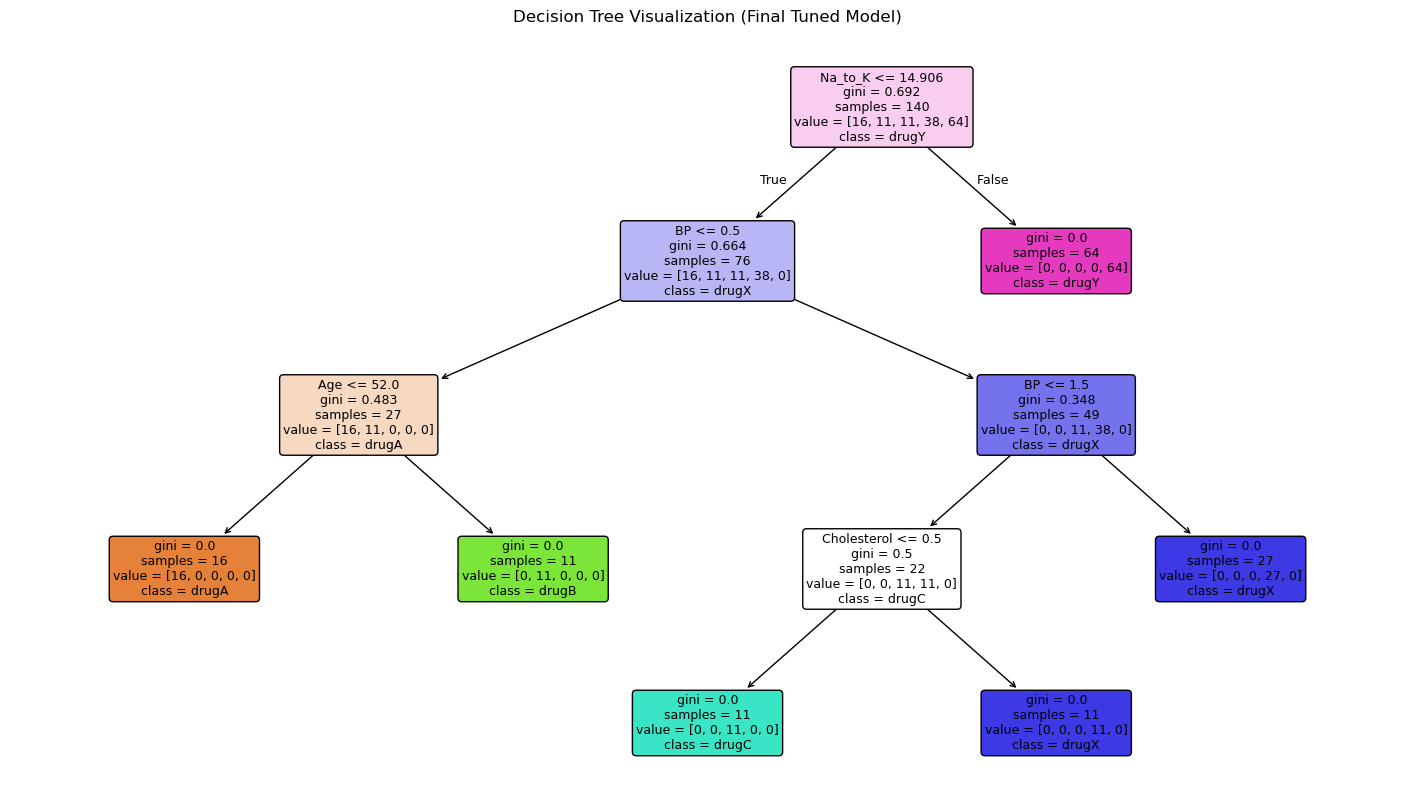

In [13]:
# ============================
# 11. DECISION TREE VISUALISATION
# ============================
plt.figure(figsize=(18, 10))
plot_tree(
    final_dt,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=9
)
plt.title("Decision Tree Visualization (Final Tuned Model)")
plt.savefig("decision_tree.png", dpi=300, bbox_inches="tight")
plt.show()

In [14]:
# ============================
# 12. PREDICT DRUG FOR A NEW PATIENT
# ============================

# Example: a new patient
#   Age: 40
#   Sex: F
#   BP: HIGH
#   Cholesterol: NORMAL
#   Na_to_K: 15.0

new_patient_raw = {
    "Age": 40,
    "Sex": "F",
    "BP": "HIGH",
    "Cholesterol": "NORMAL",
    "Na_to_K": 15.0
}

# Convert to DataFrame
new_patient_df = pd.DataFrame([new_patient_raw])

# Apply same label encoders
new_patient_df["Sex"] = label_encoders["Sex"].transform(new_patient_df["Sex"])
new_patient_df["BP"] = label_encoders["BP"].transform(new_patient_df["BP"])
new_patient_df["Cholesterol"] = label_encoders["Cholesterol"].transform(new_patient_df["Cholesterol"])

print("Encoded new patient input:")
display(new_patient_df)

predicted_drug = final_dt.predict(new_patient_df)[0]
print("Predicted drug for new patient:", predicted_drug)


Encoded new patient input:


,Age,Sex,BP,Cholesterol,Na_to_K
0,40,0,0,1,15.0


Predicted drug for new patient: drugY


In [15]:
# ============================
# 13. CROSS-VALIDATION 
# ============================
final_dt_cv = DecisionTreeClassifier(
    random_state=42,
    **best_params
)

cv_scores = cross_val_score(
    final_dt_cv,
    X_encoded,
    Y,
    cv=5,
    scoring="accuracy"
)

print("Cross-validation accuracies:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())
print("Std CV accuracy :", cv_scores.std())


Cross-validation accuracies: [1.    1.    1.    0.925 1.   ]
Mean CV accuracy: 0.985
Std CV accuracy : 0.02999999999999998


In [16]:
# ============================
# SAVE CROSS-VALIDATION SCORES TO FILE
# ============================

cv_df = pd.DataFrame({
    "Fold": [1, 2, 3, 4, 5],
    "Accuracy": cv_scores
})

cv_df.to_csv("cross_validation_scores.csv", index=False)

print("✅ Cross-validation scores saved as cross_validation_scores.csv")
cv_df


✅ Cross-validation scores saved as cross_validation_scores.csv


,Fold,Accuracy
0,1,1.000
1,2,1.000
2,3,1.000
3,4,0.925
4,5,1.000


In [17]:
# ============================
# PREDICTION WITH PROBABILITIES
# ============================

probs = final_dt.predict_proba(new_patient_df)

prob_df = pd.DataFrame(
    probs,
    columns=final_dt.classes_
)

print("Prediction Probabilities for Each Drug:")
display(prob_df)

print("Most likely drug:", final_dt.classes_[np.argmax(probs)])


Prediction Probabilities for Each Drug:


,drugA,drugB,drugC,drugX,drugY
0,0.0,0.0,0.0,0.0,1.0


Most likely drug: drugY


In [18]:
# ============================
# DECISION PATH (WHY THIS DRUG?)
# ============================

node_indicator = final_dt.decision_path(new_patient_df)
leaf_id = final_dt.apply(new_patient_df)

sample_id = 0
node_index = node_indicator.indices[
    node_indicator.indptr[sample_id] :
    node_indicator.indptr[sample_id + 1]
]

print("Decision path for the prediction:")

for node_id in node_index:
    if leaf_id[sample_id] == node_id:
        print(f"  -> Reached leaf node {node_id}")
        continue

    feature = feature_names[final_dt.tree_.feature[node_id]]
    threshold = final_dt.tree_.threshold[node_id]
    value = new_patient_df.iloc[sample_id][feature]

    direction = "≤" if value <= threshold else ">"
    print(
        f"  Node {node_id}: ({feature} = {value:.2f}) "
        f"{direction} {threshold:.2f}"
    )


Decision path for the prediction:
  Node 0: (Na_to_K = 15.00) > 14.91
  -> Reached leaf node 10


In [19]:
# ============================
# CLASS-WISE PERFORMANCE SUMMARY
# ============================

report = classification_report(Y_test, Y_test_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

display(report_df)


,precision,recall,f1-score,support
drugA,0.875,1.000,0.933,7.000
drugB,1.000,0.800,0.889,5.000
drugC,1.000,1.000,1.000,5.000
drugX,1.000,1.000,1.000,16.000
drugY,1.000,1.000,1.000,27.000
accuracy,0.983,0.983,0.983,0.983
macro avg,0.975,0.960,0.964,60.000
weighted avg,0.985,0.983,0.983,60.000


In [20]:
# ============================
# MISCLASSIFIED SAMPLE ANALYSIS
# ============================

results_df = X_test.copy()
results_df["True_Drug"] = Y_test.values
results_df["Predicted_Drug"] = Y_test_pred

misclassified = results_df[results_df["True_Drug"] != results_df["Predicted_Drug"]]

print("Number of misclassified samples:", len(misclassified))
display(misclassified.head())


Number of misclassified samples: 1


,Age,Sex,BP,Cholesterol,Na_to_K,True_Drug,Predicted_Drug
138,51,1,0,1,11.343,drugB,drugA


In [21]:
# ============================
# ROBUSTNESS TEST (NOISE)
# ============================

X_noisy = X_encoded.copy()
noise = np.random.normal(0, 0.5, X_noisy.shape)
X_noisy = X_noisy + noise

Xn_train, Xn_test, Yn_train, Yn_test = train_test_split(
    X_noisy, Y, test_size=0.3, random_state=42, stratify=Y
)

noisy_dt = DecisionTreeClassifier(random_state=42, **best_params)
noisy_dt.fit(Xn_train, Yn_train)

Yn_pred = noisy_dt.predict(Xn_test)

print("Accuracy with noisy data:", accuracy_score(Yn_test, Yn_pred))


Accuracy with noisy data: 0.7333333333333333


In [22]:
# ============================
# RANDOM FOREST COMPARISON
# ============================

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)

rf_model.fit(X_train, Y_train)

rf_pred = rf_model.predict(X_test)

rf_acc = accuracy_score(Y_test, rf_pred)

print("Random Forest Test Accuracy:", rf_acc)
print("\nRandom Forest Classification Report:\n")
print(classification_report(Y_test, rf_pred))


Random Forest Test Accuracy: 0.9833333333333333

Random Forest Classification Report:

              precision    recall  f1-score   support

       drugA       0.88      1.00      0.93         7
       drugB       1.00      0.80      0.89         5
       drugC       1.00      1.00      1.00         5
       drugX       1.00      1.00      1.00        16
       drugY       1.00      1.00      1.00        27

    accuracy                           0.98        60
   macro avg       0.97      0.96      0.96        60
weighted avg       0.99      0.98      0.98        60



In [23]:
# ============================
# STATISTICAL SIGNIFICANCE TEST (T-TEST)
# ============================

from scipy.stats import ttest_1samp

t_stat, p_value = ttest_1samp(cv_scores, 0.90)

print("T-statistic:", t_stat)
print("P-value:", p_value)

if p_value < 0.05:
    print("Result is statistically significant.")
else:
    print("Result is NOT statistically significant.")


T-statistic: 5.666666666666668
P-value: 0.004782509480211993
Result is statistically significant.


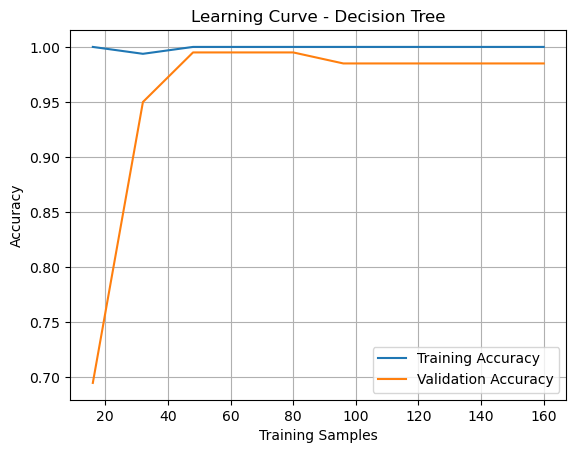

In [24]:
# ============================
# LEARNING CURVE
# ============================

from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    final_dt, X_encoded, Y, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring="accuracy"
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, label="Training Accuracy")
plt.plot(train_sizes, test_mean, label="Validation Accuracy")
plt.xlabel("Training Samples")
plt.ylabel("Accuracy")
plt.title("Learning Curve - Decision Tree")
plt.legend()
plt.grid(True)
plt.savefig("learning_curve.png", dpi=300, bbox_inches="tight")
plt.show()


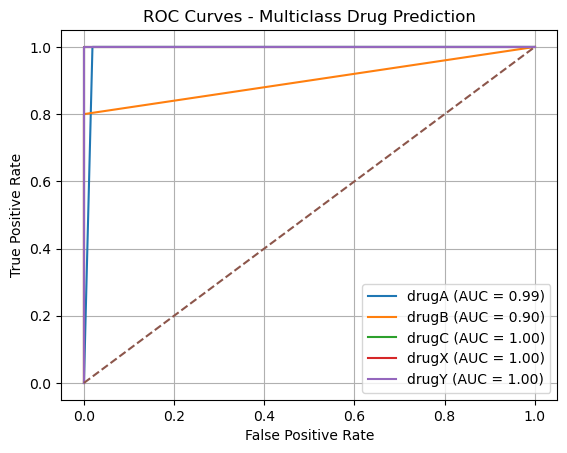

In [25]:
# ============================
# ROC CURVES (MULTICLASS)
# ============================

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

classes = final_dt.classes_
Y_test_bin = label_binarize(Y_test, classes=classes)

y_score = final_dt.predict_proba(X_test)

plt.figure()

for i in range(len(classes)):
    fpr, tpr, _ = roc_curve(Y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{classes[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Multiclass Drug Prediction")
plt.legend()
plt.grid(True)
plt.savefig("roc_curves.png", dpi=300, bbox_inches="tight")
plt.show()
